In [1]:
import os
import sys
import pickle

%load_ext autoreload
%autoreload 1
%aimport DkNN,AISE

from collections import Counter

import matplotlib.pyplot   as plt
# import matplotlib.gridspec as gridspec
# from tqdm import tqdm, tqdm_notebook

import numpy as np

# from sklearn.metrics.pairwise import cosine_distances
# from sklearn.neighbors        import NearestNeighbors

import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
from torch.utils.data.dataset import random_split
from torchvision              import datasets 
from torchvision              import transforms

from DkNN import CKNN
# import dataset_input
import utilities
from mnist_model import CNN
from attack import PGD

device = torch.device('cuda')
config = utilities.config_to_namedtuple(utilities.get_config('config_mnist.json'))

mnist_trainset = datasets.MNIST(root='./datasets', train=True, download=False, transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.,), (1,))
]))
mnist_testset = datasets.MNIST(root='./datasets', train=False, download=False, transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.,), (1,))
]))

train_loader = torch.utils.data.DataLoader(mnist_trainset,
    shuffle = True,
    batch_size = 64
)


test_loader = torch.utils.data.DataLoader(mnist_testset,
    shuffle = False,
    batch_size = 64
)

filename = 'models/mnistmodel.pt'
model = CNN().to(device)

if os.path.isfile(filename):
    print("=> loading checkpoint '{}'".format(filename))
    checkpoint = torch.load(filename,map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})"
              .format(filename, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(filename))

=> loading checkpoint 'models/mnistmodel.pt'
=> loaded checkpoint 'models/mnistmodel.pt' (epoch 55)


In [2]:
np.random.seed(1234)
ind_full = np.arange(60000)
np.random.shuffle(ind_full)
ind_partial = ind_full[:2000]
X_train_partial = mnist_trainset.data[ind_partial].unsqueeze(1)/255.
y_train_partial = mnist_trainset.targets[ind_partial]

In [3]:
def feature_space(cnnmod, num_rep, inputs, labels, device, batch_size=128):

    conv_features = [[] for _ in range(num_rep)]
    targets       = []
    predictions   = []
    print('\tRunning predictions')
    cnnmod.eval()
    for ind in range(0,inputs.size(0),batch_size):
        X,y = inputs[ind:ind+batch_size],labels[ind:ind+batch_size]
        *out_convs, out = cnnmod(X.to(device))
        y_pred = torch.max(out,1)[1]
        for i, out_conv in enumerate(out_convs):
            conv_feat = out_conv.view(out_conv.size(0), -1).detach().cpu().numpy()
            conv_features[i].append(conv_feat)
        targets.append(y.numpy())
        predictions.append(y_pred.detach().cpu().numpy())
    print('\tConcatenating results')
    conv_features = [np.concatenate(out_convs) for out_convs in conv_features]
    targets       = np.concatenate(targets)
    predictions   = np.concatenate(predictions)

    return conv_features, targets, predictions

model.eval()
conv_train, y_true, y_pred = feature_space(model, 4, X_train_partial, y_train_partial, device, 128)

	Running predictions
	Concatenating results


In [4]:
print('The accuracy of plain cnn is: {:f}'.format((y_true==y_pred).mean()))

The accuracy of plain cnn is: 0.999000


In [5]:
ind_eval = ind_full[2000:2100]
X_eval = mnist_trainset.data[ind_eval].unsqueeze(1)/255.
y_eval = mnist_trainset.targets[ind_eval]

In [6]:
X_adv = PGD(eps=40/255.,sigma=20/255.,DEVICE=device).attack_batch(model,X_eval.to(device),y_eval.to(device),batch_size=32)
*_,out = model(X_adv)
y_pred_adv = torch.max(out,1)[1]
print('The accuracy of plain cnn under PGD attacks is: {:f}'.format((y_eval.numpy()==y_pred_adv.detach().cpu().numpy()).mean())) 

The accuracy of plain cnn under PGD attacks is: 0.160000


In [7]:
# plt.figure(figsize=(10,10))
# plt.subplot(2,1,1)
# plt.imshow(X_eval[0].squeeze().numpy())
# plt.subplot(2,1,2)
# plt.imshow(adv_inp[0].squeeze().detach().cpu().numpy())

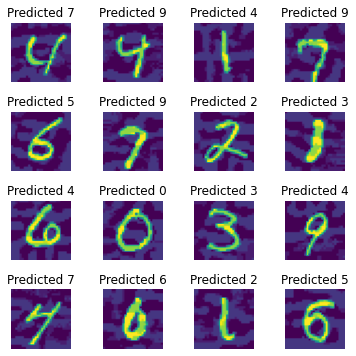

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5,wspace=.5)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_adv[i].cpu().numpy().reshape(28,28))
    plt.title(f'Predicted {y_pred_adv[i].item()}')
    plt.axis('off')

In [9]:
X_cali = mnist_testset.data[:500].unsqueeze(1)/255.
y_cali = mnist_testset.targets[:500]

#build a calibration class
class Calibration():
    def __init__(self, x_cali, y_cali):
        self.x = x_cali
        self.y = y_cali
        self.n_sample = len(y_cali)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_sample


calib_dataset = Calibration(X_cali, y_cali)
   
#Obtain the features of the calibrate dataset
#conv_cali, _, pred_cali = feature_space(model, 4, x_batch_cali, y_batch_cali, device)

In [10]:
batch_size = 64

deep_knn = CKNN(
    model         = model, 
    device        = device, 
    train_conv = conv_train,
    y_train = torch.Tensor(y_true),
    calib_dataset = calib_dataset,
    batch_size    = batch_size,
    n_neighbors   = 5,
    n_embs        = 4)

sequential_calib_loader = torch.utils.data.DataLoader(
    deep_knn.calib_dataset,
    shuffle    = False,
    batch_size = deep_knn.batch_size
)

y_pred, confidence, credibility = deep_knn.predict(X_eval.to(device))
print('Accuracy:                                  \t', (y_eval.cpu().numpy() == y_pred).mean())
print('confidence for correct predictions:\t', confidence[y_eval.cpu().numpy() == y_pred].mean())
print('credibility for correct predictions:\t', credibility[y_eval.cpu().numpy() == y_pred].mean())

Building Nearest Neighbor finders.
Building calibration set.
Accuracy:                                  	 0.96
confidence for correct predictions:	 0.98475
credibility for correct predictions:	 0.7999375


In [11]:
eps, step = (40.0,20)
at = PGD(eps=eps / 255.0, sigma=2 / 255.0, nb_iter=step)
pois_X_eval = at.attack(model, X_eval.to(device), y_eval.to(device))
y_pred, confidence, credibility = deep_knn.predict(pois_X_eval)

print('Accuracy:                                  \t', (y_eval.cpu().numpy() == y_pred).mean())
print('confidence for correct predictions:\t', confidence[y_eval.cpu().numpy() == y_pred].mean())
print('credibility for correct predictions:\t', credibility[y_eval.cpu().numpy() == y_pred].mean())

Accuracy:                                  	 0.85
confidence for correct predictions:	 0.9839058823529412
credibility for correct predictions:	 0.7288235294117648


In [12]:
X_train_partial.flatten(start_dim=1).size(),X_eval.flatten(start_dim=1).size()

(torch.Size([2000, 784]), torch.Size([100, 784]))

In [73]:
import time
from AISE import *
aise = AISE(X_train_partial.flatten(start_dim=1),y_train_partial)
start_time = time.time()
labs,bcs = aise.clonal_expansion(X_adv.cpu().flatten(start_dim=1))
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))

Building query objects...done!
Affinity maturation process starts...
Memory & plasma B-cells generated!
Total running time is 29.328940629959106s.


In [74]:
from collections import Counter
y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],labs.numpy())))
print('The accuracy of plain knn by AISE augumentation is: {}'.format((y_pred==y_eval.numpy()).mean()))

The accuracy of plain knn by AISE augumentation is: 0.8


In [75]:
aise = AISE(X_train_partial.flatten(start_dim=1),y_train_partial)
start_time = time.time()
labs,bcs = aise.clonal_expansion(X_eval.flatten(start_dim=1))
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
from collections import Counter
y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],labs.numpy())))
print('The accuracy of plain knn by AISE augumentation is: {}'.format((y_pred==y_eval.numpy()).mean()))

Building query objects...done!
Affinity maturation process starts...
Memory & plasma B-cells generated!
Total running time is 28.268940925598145s.
The accuracy of plain knn by AISE augumentation is: 0.92


In [82]:
import time
from collections import Counter
from AISE import *
aise = AISE(X_train_partial.flatten(start_dim=1),y_train_partial)
start_time = time.time()
labs,bcs = aise.clonal_expansion(X_adv.cpu().flatten(start_dim=1))
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],labs.numpy())))
print('The accuracy of plain knn by AISE augumentation is: {}'.format((y_pred==y_eval.numpy()).mean()))

Building query objects for 10 classes 2000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 100 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
25000 B cells generated!
Total running time is 26.938114166259766s.
The accuracy of plain knn by AISE augumentation is: 0.82


In [92]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN is: {}'.format((y_pred==y_eval.numpy()).mean()))

The accuaracy of plain KNN is: 0.84


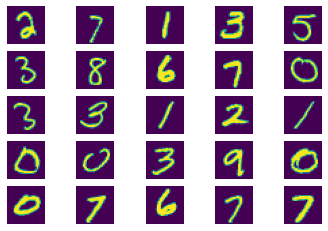

In [95]:
imgs = X_train_partial.flatten(start_dim=1).view(-1,28,28)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(imgs[i])
    plt.axis('off')

Help on function ravel in module numpy:

ravel(a, order='C')
    Return a contiguous flattened array.
    
    A 1-D array, containing the elements of the input, is returned.  A copy is
    made only if needed.
    
    As of NumPy 1.10, the returned array will have the same type as the input
    array. (for example, a masked array will be returned for a masked array
    input)
    
    Parameters
    ----------
    a : array_like
        Input array.  The elements in `a` are read in the order specified by
        `order`, and packed as a 1-D array.
    order : {'C','F', 'A', 'K'}, optional
    
        The elements of `a` are read using this index order. 'C' means
        to index the elements in row-major, C-style order,
        with the last axis index changing fastest, back to the first
        axis index changing slowest.  'F' means to index the elements
        in column-major, Fortran-style order, with the
        first index changing fastest, and the last index changing
       